In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from segmentflow import segment, view
from skimage import exposure, util
%load_ext autoreload
%autoreload 2


Loading images...
--> Images loaded as 3D array:  (1010, 650, 650)


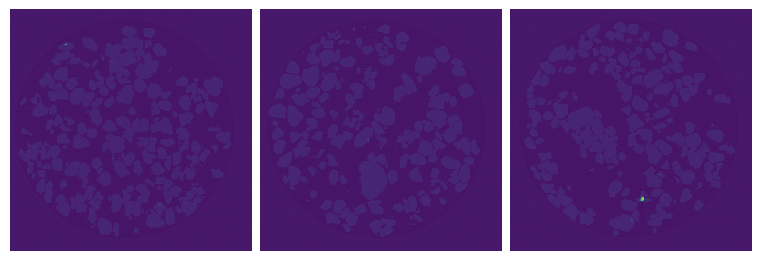

In [2]:
ui = {
    'in_dir_path'          : '../../mhe-analysis/data/FP_01',
    'file_suffix'          : 'tiff',
    'slice_crop'           : None,
    'row_crop'             : [175, 825],
    'col_crop'             : [175, 825],
    'out_dir_path'         : '../results/FP_01',
    'out_prefix'           : 'FP_01',
    'stl_overwrite'        : False,
    'view_slices'          : [250, 500, 750],
    'view_raw'             : True,
    'view_pre'             : True,
    'view_semantic'        : True,
    'view_labeled'         : True,
    'pre_seg_med_filter'   : True,
    'rescale_range'        : [0.035, 0.130],
    'thresh_nbins'         : 256,
    'view_thresh_hist'     : True,
    'thresh_hist_ylims'    : [0, 2e7],
    'perform_seg'          : True,
    'min_peak_dist'        : 6,
    'exclude_borders'      : True,
    'save_voxels'          : True,
    'create_stls'          : True,
    'n_erosions'           : 0,
    'post_seg_med_filter'  : True,
    'spatial_res'          : 1,
    'voxel_step_size'      : 1,
    'mesh_smooth_n_iters'  : None,
    'mesh_simplify_n_tris' : None,
    'mesh_simplify_factor' : None,
    'seg_fig_show'         : False,
}
#-------------#
# Load images #
#-------------#
print()
imgs = segment.load_images(
    ui['in_dir_path'],
    slice_crop=ui['slice_crop'],
    row_crop=ui['row_crop'],
    col_crop=ui['col_crop'],
    convert_to_float=True,
    file_suffix=ui['file_suffix']
)
fig, axes = view.plot_slices(
        imgs,
        slices=ui['view_slices'],
        print_slices=False,
        fig_w=7.5,
        dpi=100
    )

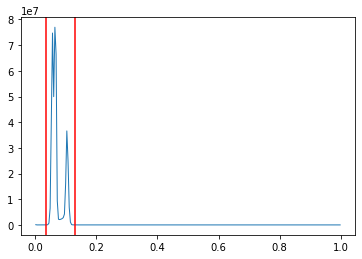

In [3]:
hist, hist_centers = exposure.histogram(imgs)
fig, ax = plt.subplots()
ax.plot(hist_centers, hist, lw=1)
ax.axvline(0.035, c='red')
ax.axvline(0.130, c='red')


Preprocessing images...
--> Applying median filter...
--> Preprocessing complete.


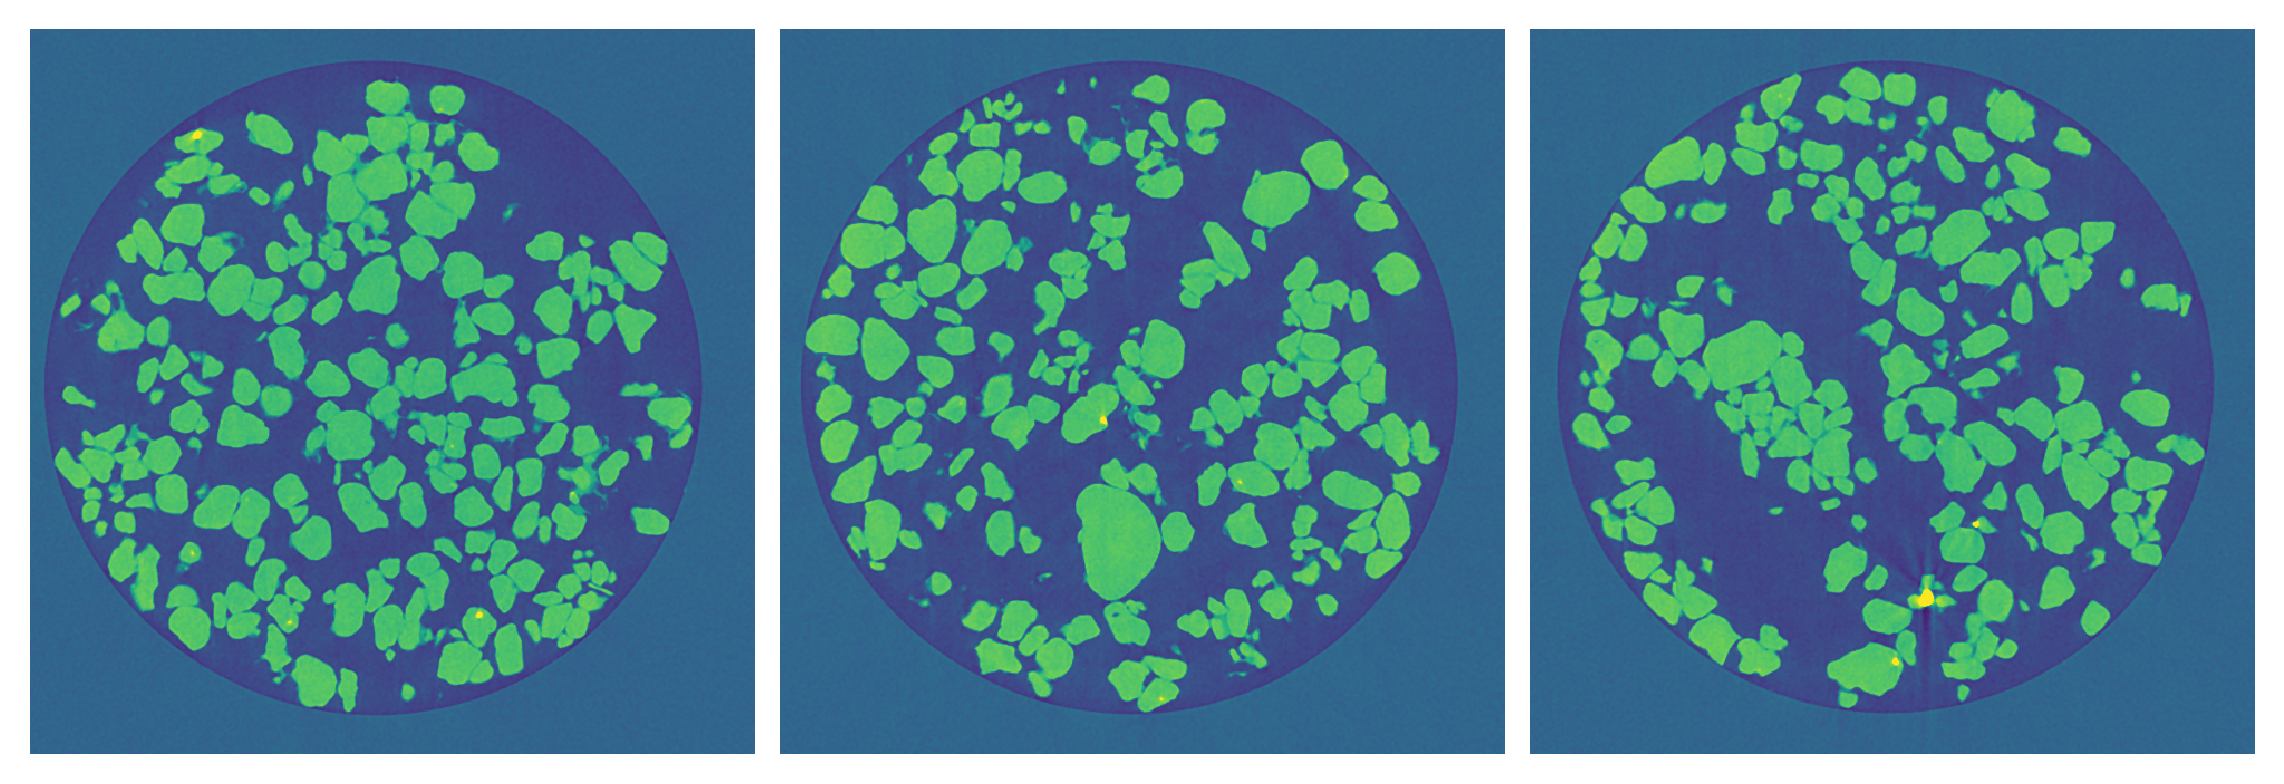

In [4]:
#-------------------#
# Preprocess images #
#-------------------#
print()
imgs_pre = segment.preprocess(
    imgs,
    median_filter=ui['pre_seg_med_filter'],
    rescale_float_range=ui['rescale_range']
    # rescale_intensity_range=ui['rescale_range']
)
fig, axes = view.plot_slices(
    imgs_pre,
    slices=ui['view_slices'],
    print_slices=False,
    fig_w=7.5,
    dpi=300
)

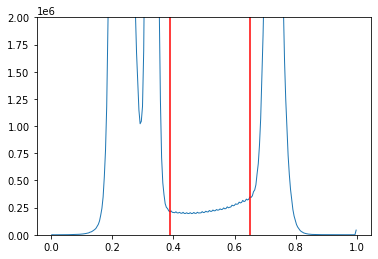

In [6]:
hist, hist_centers = exposure.histogram(imgs_pre)
fig, ax = plt.subplots(facecolor='white')
ax.plot(hist_centers, hist, lw=1)
ax.set_ylim([0, 2e6])
ax.axvline(0.39, c='red')
ax.axvline(0.65, c='red')

In [ ]:
#-----------------------#
# Semantic segmentation #
#-----------------------#
print()
if ui['view_thresh_hist']:
    thresholds, thresh_fig, thresh_ax = segment.threshold_multi_min(
        imgs_pre, nbins=ui['thresh_nbins'], return_fig_ax=True,
        ylims=ui['thresh_hist_ylims']
    )
else:
    thresholds = segment.threshold_multi_min(
        imgs_pre, nbins=ui['thresh_nbins'], return_fig_ax=False,
    )
imgs_semantic = segment.isolate_classes(imgs_pre, thresholds)
if ui['view_semantic']:
    fig, axes = view.plot_slices(
            imgs_semantic,
            slices=ui['view_slices'],
            print_slices=False,
            fig_w=7.5,
            dpi=100
        )


In [ ]:
thresholds = [10000, 45000]
imgs_semantic = segment.isolate_classes(imgs_pre, thresholds)
if ui['view_semantic']:
    fig, axes = view.plot_slices(
            imgs_semantic,
            slices=ui['view_slices'],
            print_slices=False,
            fig_w=7.5,
            # cmap='gray',
            dpi=300
        )


In [ ]:

#-----------------------#
# Instance segmentation #
#-----------------------#
if ui['perform_seg']:
    print()
    imgs = None
    imgs_pre = None
    imgs_labeled = segment.watershed_segment(
        imgs_semantic==len(thresholds),
        min_peak_distance=ui['min_peak_dist'],
        exclude_borders=ui['exclude_borders'],
        return_dict=False
    )
    # Merge semantic and instance segmentations
    imgs_labeled = segment.merge_segmentations(imgs_semantic, imgs_labeled)
    if ui['view_labeled']:
        fig, axes = view.plot_color_labels(
            imgs_labeled,
            slices=ui['view_slices'],
            fig_w=7.5,
            dpi=100
        )
    if ui['save_voxels']:
        segment.save_images(
            imgs_labeled,
            Path(ui['out_dir_path']) / f"{ui['out_prefix']}_labeled_voxels"
        )

#----------------------------------------#
# Create Surface Meshes of Each Particle #
#----------------------------------------#
if ui['perform_seg'] and ui['create_stls']:
    print()
    segment.save_as_stl_files(
        imgs_labeled,
        ui['out_dir_path'],
        ui['out_prefix'],
        suppress_save_msg=ui['suppress_save_msg'],
        slice_crop=ui['slice_crop'],
        row_crop=ui['row_crop'],
        col_crop=ui['col_crop'],
        stl_overwrite=ui['overwrite'],
        spatial_res=ui['spatial_res'],
        n_erosions=ui['n_erosions'],
        median_filter_voxels=ui['post_seg_med_filter'],
        voxel_step_size=ui['voxel_step_size'],
    )

    #----------------------------------------------#
    # Postprocess surface meshes for each particle #
    #----------------------------------------------#
    if (
        ui['mesh_smooth_n_iters'] is not None
        or ui['mesh_simplify_n_tris'] is not None
        or ui['mesh_simplify_factor'] is not None
    ):
        print()
        # Iterate through each STL file, load the mesh, and smooth/simplify
        mesh.postprocess_meshes(
            ui['stl_dir_location'],
            smooth_iter=ui['mesh_smooth_n_iters'],
            simplify_n_tris=ui['mesh_simplify_n_tris'],
            iterative_simplify_factor=ui['mesh_simplify_factor'],
            recursive_simplify=False, resave_mesh=True
        )
